The data comes from the Global Summary of the Day (GSOD) weather from the National Oceanographic and Atmospheric Administration (NOAA) for 9,000 weather stations.  The three stations are Bellingham Intl, Padilla Bay Reserve and Skagit Regional.  The data has been cleaned up and normalized and loaded in the file six_stations.pkl.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
import pickle
six = pickle.load(open('six_stations.pkl', 'rb'))
six

[[(1, 37.4),
  (2, 37.4),
  (3, 39.2),
  (4, 46.4),
  (5, 51.8),
  (6, 55.4),
  (7, 46.4),
  (8, 46.4),
  (9, 46.4),
  (10, 44.6),
  (11, 46.4),
  (12, 48.2),
  (13, 44.6),
  (14, 46.4),
  (15, 51.8),
  (16, 53.6),
  (17, 51.8),
  (18, 55.4),
  (19, 51.8),
  (20, 48.2),
  (21, 44.6),
  (22, 50.0),
  (23, 55.4),
  (24, 57.2),
  (25, 57.2),
  (26, 66.2),
  (27, 60.8),
  (28, 53.6),
  (29, 51.8),
  (30, 51.8),
  (31, 48.2),
  (32, 48.2),
  (33, 48.2),
  (34, 48.2),
  (35, 50.0),
  (36, 57.2),
  (37, 59.0),
  (38, 57.2),
  (39, 60.8),
  (40, 57.2),
  (41, 55.4),
  (42, 57.2),
  (43, 55.4),
  (44, 57.2),
  (45, 55.4),
  (46, 51.8),
  (47, 57.2),
  (48, 53.6),
  (49, 55.4),
  (50, 55.4),
  (51, 51.8),
  (52, 57.2),
  (53, 57.2),
  (54, 53.6),
  (55, 53.6),
  (56, 51.8),
  (57, 51.8),
  (58, 51.8),
  (59, 55.4),
  (60, 51.8),
  (61, 50.0),
  (62, 48.2),
  (63, 51.8),
  (64, 53.6),
  (65, 53.6),
  (66, 55.4),
  (67, 57.2),
  (68, 55.4),
  (69, 51.8),
  (70, 53.6),
  (71, 54.0),
  (72, 54.0),
 

In [3]:
np.array(six[0][0:10])[:,1]

array([37.4, 37.4, 39.2, 46.4, 51.8, 55.4, 46.4, 46.4, 46.4, 44.6])

In [4]:
for i in range(6):
    six[i] = np.array(six[i])[:,1]
sixave = np.zeros(360)
for i in range(6):
    sixave += six[i][:360]
sixave = sixave/6.0

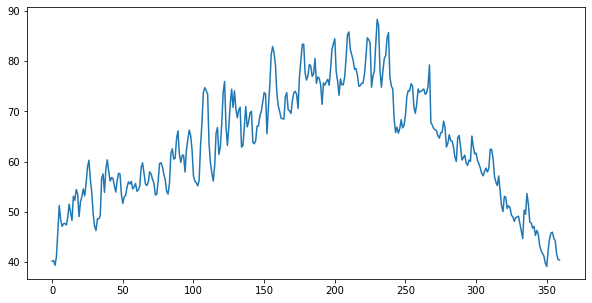

In [5]:
sixave
plt.figure( figsize=(10,5))
plt.plot(sixave)


In [6]:
class MyLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 100)
        self.linear = nn.Linear(100, 1)
        self.c_h = (torch.zeros(1,1,100),
                    torch.zeros(1,1,100))
    def forward(self, x):
        h, self.c_h= self.lstm(x.view(len(x) ,1, -1), self.c_h)
        predictions = self.linear(h.view(len(x), -1))
        return predictions[-1]

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(sixave.reshape(-1, 1))
train_six_normalized =[]

In [8]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 7

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

we now add the data from stations 1 and 2 to the average to make the training set.

In [9]:
for i in range(1,2):
    scaler = MinMaxScaler(feature_range=(-1, 1))    
    train_data_normalized2 = scaler.fit_transform(six[i].reshape(-1, 1))
    train_data_normalized2 = torch.FloatTensor(train_data_normalized2).view(-1)
    train_inout_seq2 = create_inout_sequences(train_data_normalized2, train_window)
    train_inout_seq += train_inout_seq2

In [10]:
model = MyLSTM()
loss_function = nn.MSELoss()
hidden_layer_size = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs =2002 #52

for i in range(epochs):
    seq_err = 0.0
    for _ in range(500):
        num = np.random.randint(len(train_inout_seq))
        seq = train_inout_seq[num][0]
        labels = train_inout_seq[num][1]
        optimizer.zero_grad()
        model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                        torch.zeros(1, 1, hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        seq_err+= single_loss.item()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        print(f'seq: {i:3} loss: {seq_err:10.8f}')
    if seq_err < 0.07:
        break

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01361546
seq:   1 loss: 16.55300427
epoch:  26 loss: 0.00212406
seq:  26 loss: 7.29426551
epoch:  51 loss: 0.00006852
seq:  51 loss: 8.19752527
epoch:  76 loss: 0.01162369
seq:  76 loss: 7.63863247
epoch: 101 loss: 0.00441794
seq: 101 loss: 6.92321737
epoch: 126 loss: 0.05422363
seq: 126 loss: 7.44168163
epoch: 151 loss: 0.00297821
seq: 151 loss: 6.78063166
epoch: 176 loss: 0.00000425
seq: 176 loss: 6.17051580
epoch: 201 loss: 0.00039697
seq: 201 loss: 5.45375035
epoch: 226 loss: 0.00238760
seq: 226 loss: 5.75593569
epoch: 251 loss: 0.00034696
seq: 251 loss: 5.46548711
epoch: 276 loss: 0.00426952
seq: 276 loss: 4.20271654
epoch: 301 loss: 0.00378144
seq: 301 loss: 3.59760243
epoch: 326 loss: 0.00011326
seq: 326 loss: 2.92363610
epoch: 351 loss: 0.00424886
seq: 351 loss: 2.47710691
epoch: 376 loss: 0.00000891
seq: 376 loss: 1.73292101
epoch: 401 loss: 0.00000189
seq: 401 loss: 2.04424065
epoch: 426 loss: 0.00201200
seq: 426 loss: 1.16446610
epoch: 451 loss: 0.00055838

In [11]:
use_saved_model = False
if use_saved_model:
    model = MyLSTM()
    model.load_state_dict(torch.load('lstm-modelave_final')) 
    
save_model = True
if save_model:
    torch.save(model.state_dict(), 'lstm-modelave_newer')


In [12]:
#load the saved model uncoment this one.
model.load_state_dict(torch.load('lstm-modelave_final')) 

<All keys matched successfully>

The following function will take a data set consisting of one year of high temperature readings and create a sliding window of 12 days and invoke the network to get the 13th day.  this predicted 13th day is appended to a list of predictions.  

In [13]:
def OneStep(data):
    print('data set length =', len(data))
    train_window = 7
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))
    fut_pred = len(data) -train_window
    test_inputs = train_data_normalized[0:train_window].reshape(train_window).tolist()
    s2 = train_data_normalized.reshape(len(data)).tolist()
    realdata = data
    model.eval()
    preds = test_inputs.copy()
    t2 = test_inputs
    hidden_layer_size = 100
    x = 0
    for i in range(fut_pred):
        seq = torch.FloatTensor(t2[i:])
        model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                        torch.zeros(1, 1, hidden_layer_size))
        x = model(seq).item()
        #print(seq[-1],s2[train_window+i], x)
        preds.append(x)
        t2.append(s2[train_window+i])  
    actual_predictions = scaler.inverse_transform(np.array(preds ).reshape(-1, 1))

    print(len(actual_predictions))
    plt.figure( figsize=(10,5))
    plt.plot(data)
    plt.plot(actual_predictions[0:])
    err = 0.0
    errs = 0.0
    cnt = 0
    badday  =0.0
    errsq = 0.0
    
    for i in range(1,len(actual_predictions)):
        err += np.abs(realdata[i-1]-actual_predictions[i])
        errs += np.abs(realdata[i-1]-realdata[i])
        errsq +=(realdata[i-1]-actual_predictions[i])*(realdata[i-1]-actual_predictions[i])
        if (realdata[i-1]-actual_predictions[i]) > 10 or (realdata[i-1]-actual_predictions[i]) < -10:
            badday += np.abs((realdata[i-1]-actual_predictions[i]))
            cnt +=1
    print("mean daily error =", err[0]/360, ' degrees')
    print("mean daily change =", errs/360, ' degrees')
    err = np.sqrt(errsq)/360.0
    print("l2 error=", err)
    print('days where prediction error exceeds 10 degrees =', cnt)
    if cnt > 0:
        print("average error on those days = ", badday/cnt)    
    print('------------------------------------') 
    err = 0.0
    cnt = 0
    badday  =0.0
    errsq = 0.0    
    for i in range(len(actual_predictions)):
        err += np.abs(realdata[i]-actual_predictions[i])
        errsq +=(realdata[i]-actual_predictions[i])*(realdata[i]-actual_predictions[i])
        if (realdata[i]-actual_predictions[i]) > 10 or (realdata[i]-actual_predictions[i]) < -10:
            badday += np.abs((realdata[i]-actual_predictions[i]))
            cnt +=1
    print("mean daily error =", err[0]/360, ' degrees')
    err = np.sqrt(errsq)/360.0
    print("l2 error=", err)
    print('days where prediction error exceeds 10 degrees =', cnt)
    if cnt > 0:
        print("average error on those days = ", badday/cnt)    

data set length = 360
360
mean daily error = 2.077269812902366  degrees
mean daily change = 2.0523611111111126  degrees
l2 error= [0.14954447]
days where prediction error exceeds 10 degrees = 1
average error on those days =  [11.54051089]
------------------------------------
mean daily error = 0.17090490862451094  degrees
l2 error= [0.01213879]
days where prediction error exceeds 10 degrees = 0


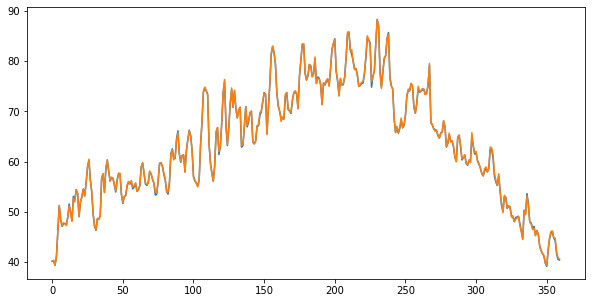

In [14]:
OneStep(sixave)

data set length = 365
365
mean daily error = 2.6686343983850547  degrees
mean daily change = 3.0849999999999946  degrees
l2 error= [0.19716346]
days where prediction error exceeds 10 degrees = 8
average error on those days =  [13.24480223]
------------------------------------
mean daily error = 4.036893013653654  degrees
l2 error= [0.29494252]
days where prediction error exceeds 10 degrees = 19
average error on those days =  [15.18822175]


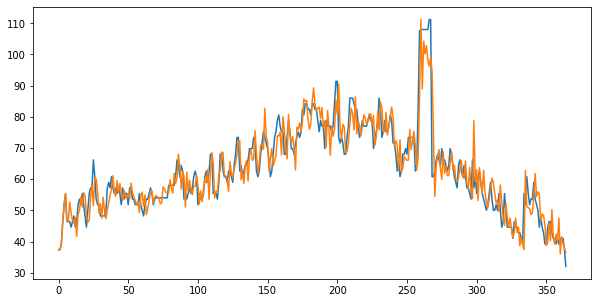

In [15]:
OneStep(six[0])

data set length = 365
365
mean daily error = 3.120526880440821  degrees
mean daily change = 3.0274999999999985  degrees
l2 error= [0.23554475]
days where prediction error exceeds 10 degrees = 16
average error on those days =  [12.5334438]
------------------------------------
mean daily error = 0.21938741828936278  degrees
l2 error= [0.01498749]
days where prediction error exceeds 10 degrees = 0


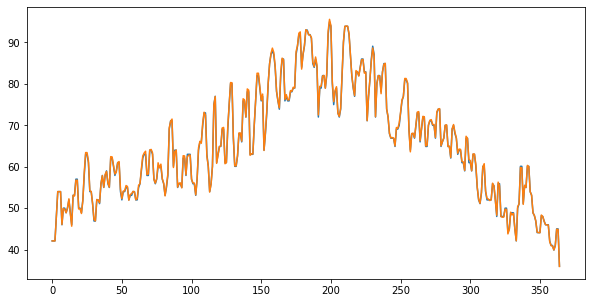

In [16]:
OneStep(six[1])

data set length = 365
365
mean daily error = 2.5064648886656187  degrees
mean daily change = 2.725555555555555  degrees
l2 error= [0.17272117]
days where prediction error exceeds 10 degrees = 4
average error on those days =  [11.06481705]
------------------------------------
mean daily error = 3.1848425185338898  degrees
l2 error= [0.22481614]
days where prediction error exceeds 10 degrees = 13
average error on those days =  [12.27472345]


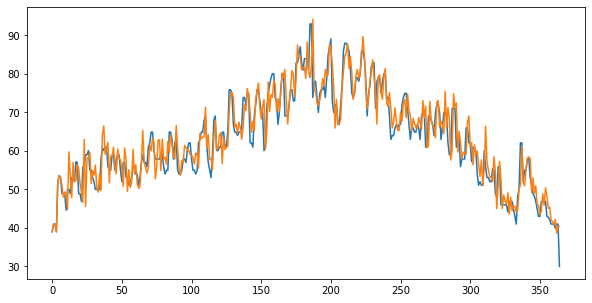

In [17]:
OneStep(six[2])

data set length = 360
360
mean daily error = 2.5227805450372385  degrees
mean daily change = 3.2049999999999943  degrees
l2 error= [0.18161295]
days where prediction error exceeds 10 degrees = 2
average error on those days =  [18.67679453]
------------------------------------
mean daily error = 3.649971005599944  degrees
l2 error= [0.25276097]
days where prediction error exceeds 10 degrees = 13
average error on those days =  [12.70866734]


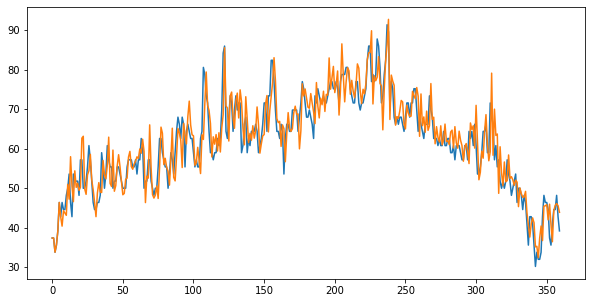

In [18]:
OneStep(six[3])

data set length = 365
365
mean daily error = 2.387250302913081  degrees
mean daily change = 3.042777777777776  degrees
l2 error= [0.16588003]
days where prediction error exceeds 10 degrees = 3
average error on those days =  [10.95484737]
------------------------------------
mean daily error = 3.7375312935157385  degrees
l2 error= [0.26008139]
days where prediction error exceeds 10 degrees = 18
average error on those days =  [12.62497787]


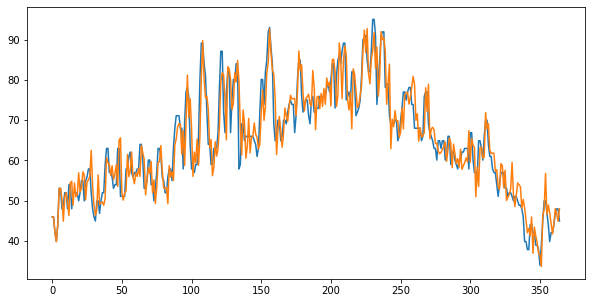

In [19]:
OneStep(six[4])

data set length = 365
365
mean daily error = 2.606872464044847  degrees
mean daily change = 3.0425000000000013  degrees
l2 error= [0.18242362]
days where prediction error exceeds 10 degrees = 3
average error on those days =  [12.55276952]
------------------------------------
mean daily error = 3.8866060675390903  degrees
l2 error= [0.26729942]
days where prediction error exceeds 10 degrees = 18
average error on those days =  [13.02731134]


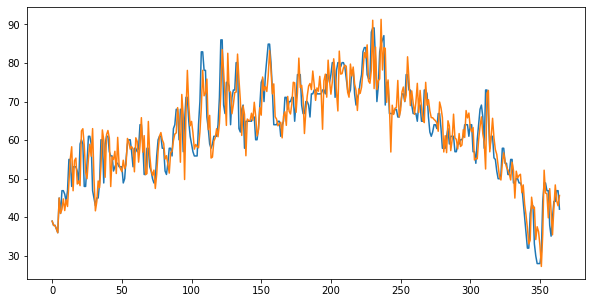

In [20]:
OneStep(six[5])